In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation, SimpleRNN
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import itertools
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
upright = os.listdir(r'/content/drive/MyDrive/posture/Upright Sitting')
Crossed_legs = os.listdir(r'/content/drive/MyDrive/posture/Crossing legs')
slant_bending = os.listdir(r'/content/drive/MyDrive/posture/Slant Bending')
Lordosis = os.listdir(r'/content/drive/MyDrive/posture/Lordosis')
slouching = os.listdir(r'/content/drive/MyDrive/posture/Slouching')

In [3]:
img_w, img_h = 225, 225 #setting the image width and height for easy processing
X = []
y = []

for i in upright:
    try:
        img = Image.open('/content/drive/MyDrive/posture/Upright Sitting/' + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError: # it passes an image that wasn't correctly identified
        pass
    
for i in Crossed_legs:
    try:
        img = Image.open("/content/drive/MyDrive/posture/Crossing legs/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass
    
for i in slant_bending:
    try:
        img = Image.open("/content/drive/MyDrive/posture/Slant Bending/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass
    
for i in Lordosis:
    try:
        img = Image.open("/content/drive/MyDrive/posture/Lordosis/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass
    
for i in slouching:
    try:
        img = Image.open("/content/drive/MyDrive/posture/Slouching/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass
    
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

# I resized each image to our manually defined width and height(img_w, img_h)
# I also changed the images to an array



(219, 225, 225, 3) (219,)


In [4]:
x = X.astype('float32')
x /= 255

#scaler = MinMaxScaler()
#x = scaler.fit_transform(x)

num_classes = 3

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[1. 0. 0.]


In [5]:
# splitting our dataset into train and test
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.3, random_state=5)
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,test_size=0.3,random_state=5)


print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

Number of train: 107
Number of validation: 46
Number of test: 66


In [6]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20.,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=30.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=0.2,
    vertical_flip=0.2,
    rescale=None)

datagen.fit(x_train)

In [7]:
TLA = tf.keras.applications.InceptionV3(input_shape=(225,225,3),include_top=False,weights="imagenet")

87924736/87910968 [==============================] - 1s 0us/step


In [8]:
for layer in TLA.layers[:-10]:
    layer.trainable=False

In [13]:
def create_model( dropout_rate):
  model_Inception=Sequential()
  model_Inception.add(TLA)
  model_Inception.add(Dropout(0.2))
  model_Inception.add(Flatten())
  model_Inception.add(Dense(128, activation='relu'))
  model_Inception.add(Dense(128, activation='relu'))
  model_Inception.add(Dense(3, activation='softmax'))
  model_Inception.compile(optimizer='rmsprop', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)
  return model_Inception

    # Declare parameter values
dropout_rate = 0.1
epochs = 1
batch_size = 20
learn_rate = 0.001

# Create the model object by calling the create_model function we created above
model_Inception = create_model(dropout_rate)

# Fit the model onto the training data
model_Inception.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

6/6 [==============================] - 20s 2s/step - loss: 46.1790 - accuracy: 0.4486 - precision: 0.4466 - recall: 0.4299 - auc: 0.5752 - f1_score: 0.6790


In [18]:
# Create the model
model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the parameters that you wish to use in your Grid Search along
# with the list of values that you wish to try out
learn_rate = [0.001, 0.02, 0.2]
dropout_rate = [0.0, 0.2, 0.4]
batch_size = [10, 20, 30]
epochs = [1, 5, 10]

seed = 42

# Make a dictionary of the grid search parameters
param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs )

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=KFold(random_state=None),verbose=10)

grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START batch_size=10, dropout_rate=0.0, epochs=1..................
3/3 [==============================] - 5s 654ms/step - loss: 21.0956 - accuracy: 0.1818 - precision: 0.1818 - recall: 0.1818 - auc: 0.3864 - f1_score: 0.2000
[CV 1/5; 1/27] END batch_size=10, dropout_rate=0.0, epochs=1;, score=0.182 total time=  23.8s
[CV 2/5; 1/27] START batch_size=10, dropout_rate=0.0, epochs=1..................
3/3 [==============================] - 5s 649ms/step - loss: 17.7741 - accuracy: 0.1818 - precision: 0.1818 - recall: 0.1818 - auc: 0.3864 - f1_score: 0.4000
[CV 2/5; 1/27] END batch_size=10, dropout_rate=0.0, epochs=1;, score=0.182 total time=  21.6s
[CV 3/5; 1/27] START batch_size=10, dropout_rate=0.0, epochs=1..................
3/3 [==============================] - 5s 588ms/step - loss: 6.6215 - accuracy: 0.4286 - precision: 0.4286 - recall: 0.4286 - auc: 0.6621 - f1_score: 0.9000
[CV 3/5; 1/27] END batch_size=10, 

In [ ]:
# My neural network consists of 3 layers densely connected
# dropout helps prevent over fitting of the model when testing it
model_Inception=Sequential()
model_Inception.add(TLA)
model_Inception.add(Dropout(0.2))
model_Inception.add(Flatten())
model_Inception.add(Dense(128, activation='relu'))
model_Inception.add(Dense(128, activation='relu'))
model_Inception.add(Dense(3, activation='softmax'))
model_Inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 28,373,411
Trainable params: 28,338,979
No

In [9]:
# here i am defining my performance metrics to check the performance of the model
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 3*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'recall',patience = 10,verbose = 1,factor = 0.70, min_lr = 1e-5)
# the above line of code reduces the learning rate when there is no improvement to the metric
# i added this line of code because i trained the model without it and the performance was stagnant
# the performance was stuck on 0.96nnn as the accuracy so i added the line of code to reduce
# the learing rate after two epochs
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=50)

model_Inception.compile(optimizer='rmsprop', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [ ]:
# this is where i fit and trained my model
%time
history=model_Inception.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs
Epoch 1/5
4/4 [==============================] - 84s 16s/step - loss: 16.3224 - accuracy: 0.3178 - precision: 0.2747 - recall: 0.2336 - auc: 0.4917 - f1_score: 0.3494 - val_loss: 28137344.0000 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.6027 - lr: 0.0010
Epoch 2/5
4/4 [==============================] - 59s 14s/step - loss: 3.2377 - accuracy: 0.4019 - precision: 0.4394 - recall: 0.2710 - auc: 0.5953 - f1_score: 0.3398 - val_loss: 558931.6250 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.6027 - lr: 0.0010
Epoch 3/5
4/4 [==============================] - 59s 14s/step - loss: 1.2991 - accuracy: 0.3832 - precision: 0.5714 - recall: 0.0374 - auc: 0.5773 - f1_score: 0.1287 - val_loss: 280329.4688 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.6027 - lr: 0.00

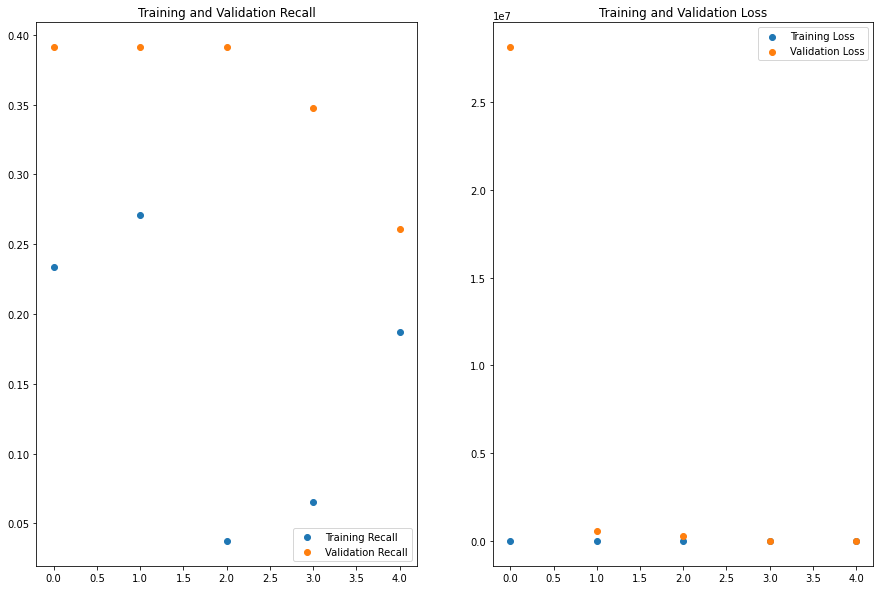

In [ ]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)
print('roc_auc_score for KNN: ', roc_auc_score(y_test, y_pred))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - KNN')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
Classification Report
                     precision    recall  f1-score   support

       Good posture       0.36      1.00      0.53        24
indifferent posture       0.00      0.00      0.00        15
        Bad posture       0.00      0.00      0.00        27

           accuracy                           0.36        66
          macro avg       0.12      0.33      0.18        66
       weighted avg       0.13      0.36      0.19        66



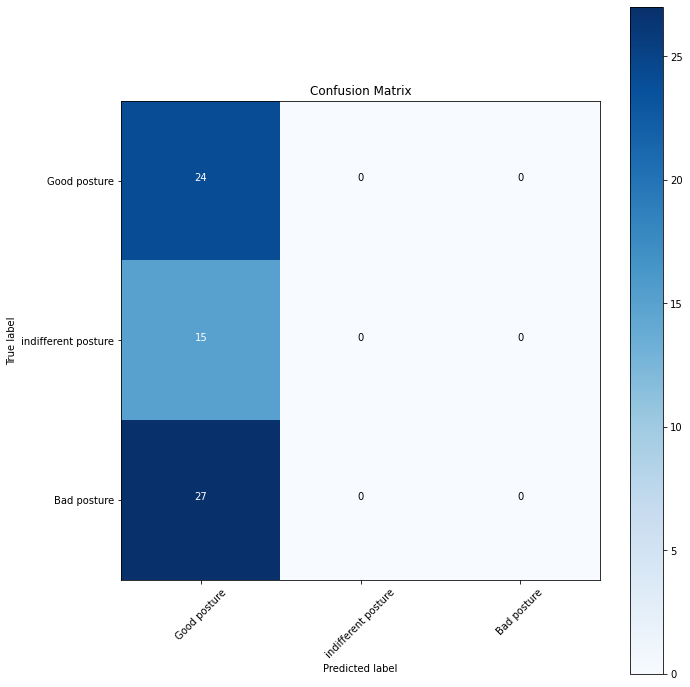

In [ ]:
# here i want to define and plot my confusion matrix
# and also my classification report
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred = (model_Inception.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["Good posture", "indifferent posture", "Bad posture"]

Y_pred = np.argmax(model_Inception.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))


In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test_c, Y_pred)
print('roc_auc_score for inception: ', roc_auc_score(y_test, y_pred))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Inception')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ValueError: ignored

In [ ]:
TLA1 = tf.keras.applications.vgg16.VGG16(input_shape=(225,225,3),include_top=False,weights="imagenet")

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in TLA1.layers[:-10]:
    layer.trainable=False

In [ ]:
model_Vgg16=Sequential()
model_Vgg16.add(TLA1)
model_Vgg16.add(Dropout(0.2))
model_Vgg16.add(Flatten())
model_Vgg16.add(Dense(128, activation='relu'))
model_Vgg16.add(Dense(128, activation='relu'))
model_Vgg16.add(Dense(3, activation='softmax'))
model_Vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               3211392   
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17,942,979
Trainable params: 16,797,571


In [ ]:
model_Vgg16.compile(optimizer='rmsprop', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [ ]:
%time
history=model_Vgg16.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 50,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 21.7 µs
Epoch 1/50
4/4 [==============================] - 153s 38s/step - loss: 714.4534 - accuracy: 0.4248 - precision: 0.4453 - recall: 0.3725 - auc: 0.6019 - f1_score: 0.4092 - val_loss: 1.9279 - val_accuracy: 0.2609 - val_precision: 0.2609 - val_recall: 0.2609 - val_auc: 0.4445 - val_f1_score: 0.4018 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 144s 36s/step - loss: 1.3374 - accuracy: 0.3551 - precision: 0.2188 - recall: 0.0654 - auc: 0.4972 - f1_score: 0.0820 - val_loss: 1.1056 - val_accuracy: 0.3913 - val_precision: 0.5000 - val_recall: 0.0217 - val_auc: 0.5637 - val_f1_score: 0.1000 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 142s 35s/step - loss: 1.0821 - accuracy: 0.4673 - precision: 0.4359 - recall: 0.1589 - auc: 0.6019 - f1_score: 0.2385 - val_loss: 1.0926 - val_accuracy: 0.3913 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5724 - val_f1_score: 0.0000e+00 - lr: 0.

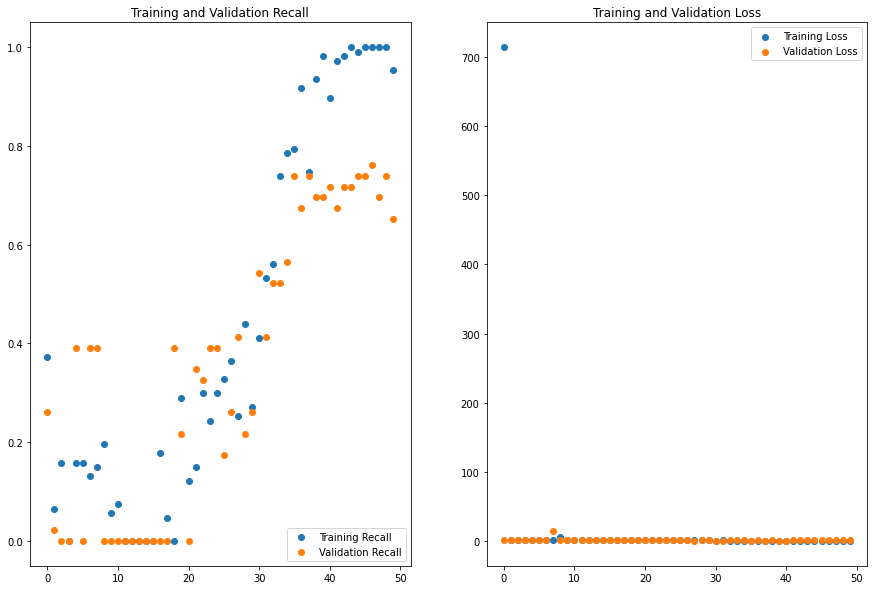

In [ ]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
Classification Report
                     precision    recall  f1-score   support

       Good posture       0.76      0.79      0.78        24
indifferent posture       0.73      0.73      0.73        15
        Bad posture       0.85      0.81      0.83        27

           accuracy                           0.79        66
          macro avg       0.78      0.78      0.78        66
       weighted avg       0.79      0.79      0.79        66



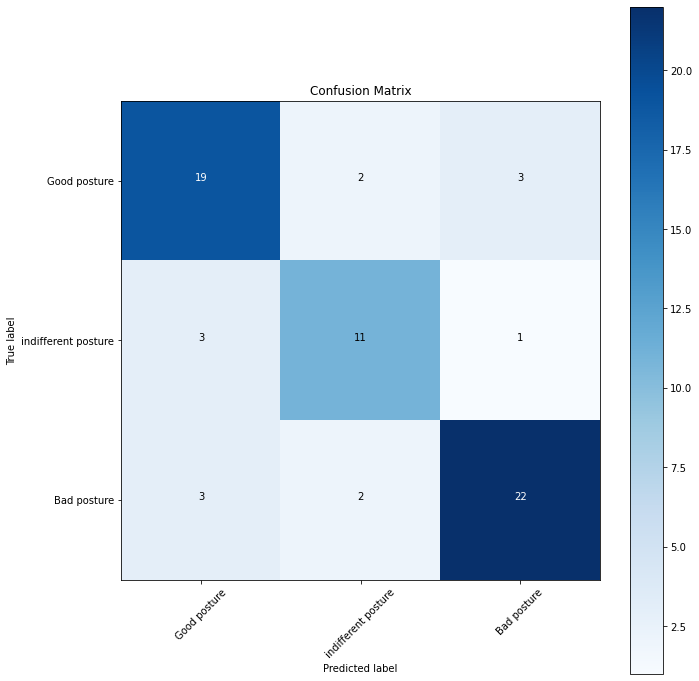

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred1 = (model_Vgg16.predict(x_test) > 0.5).astype("int32")

y_test_c1 = np.argmax(y_test, axis=1)
target_names = ["Good posture", "indifferent posture", "Bad posture"]

Y_pred1 = np.argmax(model_Vgg16.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c1, Y_pred1)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c1, Y_pred1, target_names=target_names))


In [ ]:
TLA2 = tf.keras.applications.resnet50.ResNet50(input_shape=(225,225,3),include_top=False,weights="imagenet")

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
for layer in TLA2.layers[:-10]:
    layer.trainable=False

In [ ]:
model_resnet=Sequential()
model_resnet.add(TLA2)
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(3, activation='softmax'))
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               16777344  
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 40,381,955
Trainable params: 21,259,907


In [ ]:
model_resnet.compile(optimizer='rmsprop', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [ ]:
%time
history=model_resnet.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 50,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.1 µs


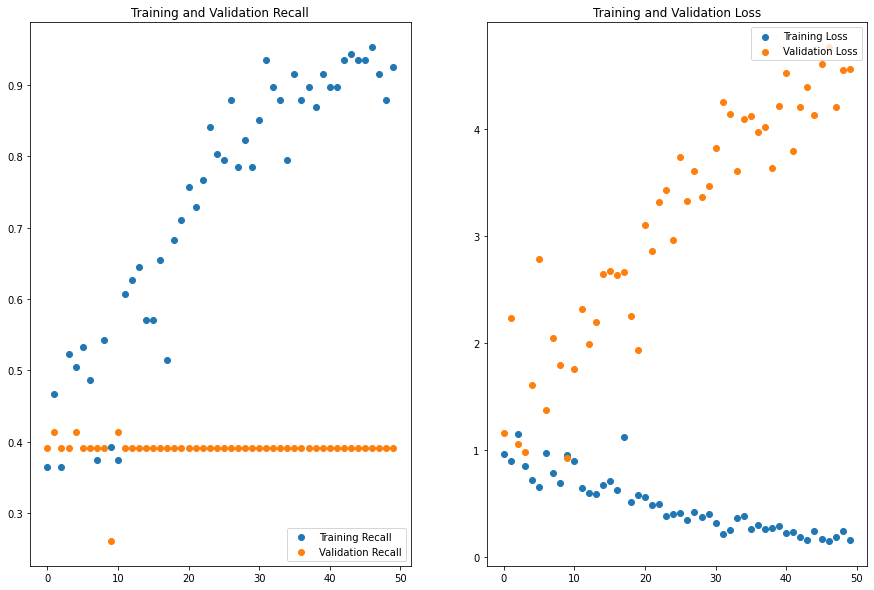

In [ ]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
Classification Report
                     precision    recall  f1-score   support

       Good posture       0.00      0.00      0.00        24
indifferent posture       0.00      0.00      0.00        15
        Bad posture       0.41      1.00      0.58        27

           accuracy                           0.41        66
          macro avg       0.14      0.33      0.19        66
       weighted avg       0.17      0.41      0.24        66



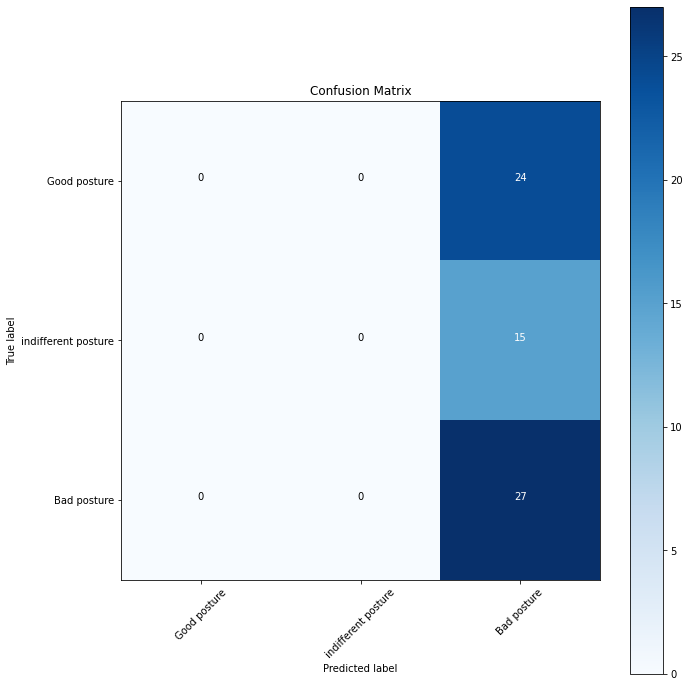

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred2 = (model_resnet.predict(x_test) > 0.5).astype("int32")

y_test_c2 = np.argmax(y_test, axis=1)
target_names = ["Good posture", "indifferent posture", "Bad posture"]

Y_pred2 = np.argmax(model_resnet.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c2, Y_pred2)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c2, Y_pred2, target_names=target_names))